In [62]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle

plt.style.use('fivethirtyeight')

# Load data

In [2]:
train = []
test = []

for line in open(os.getcwd() + '/data/imbd_train.txt', 'r', encoding='latin1'):
    train.append(line.strip())

for line in open(os.getcwd() + '/data/imbd_test.txt', 'r', encoding='latin1'):    
    test.append(line.strip())

# Feature engineering

REMOVING NON-TEXT CHARACTERS

In [3]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    
    # Para todas las reviews en minuscula, sustituye algunas cosas por espacio y otras por vacio.
    reviews = [REPLACE_NO_SPACE.sub('', line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(' ', line) for line in reviews]
    
    return reviews

In [4]:
train_clean = preprocess_reviews(train)
test_clean = preprocess_reviews(test)

In [5]:
example1 = pd.DataFrame(
    data={
        'Before': [train[0][:99], train[1][:99], train[2][:99]],
        'After': [train_clean[0][:99], train_clean[1][:99], train_clean[2][:99]]
    },
    index=[0,1,2]
)
example1

,Before,After
0,Bromwell High is a cartoon comedy. It ran at t...,bromwell high is a cartoon comedy it ran at th...
1,Homelessness (or Houselessness as George Carli...,homelessness or houselessness as george carlin...
2,Brilliant over-acting by Lesley Ann Warren. Be...,brilliant over acting by lesley ann warren bes...


REMOVING STOP WORDS

In [6]:
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('english')
stop_words[:10]

[nltk_data] Downloading package stopwords to /home/n0t10n/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [7]:
def remove_stop_words(corpus):
    clean_corpus = []
    
    for review in corpus:  
        clean_corpus.append(
            ' '.join([word for word in review.split() if word not in stop_words])
        )
        
    return clean_corpus

In [8]:
stw_train = remove_stop_words(train_clean)
stw_test = remove_stop_words(test_clean)

TARGET

In [9]:
train_target = [1 if i < len(train)/2 else 0 for i in range(len(train))]
test_target = [1 if i < len(test)/2 else 0 for i in range(len(test))]

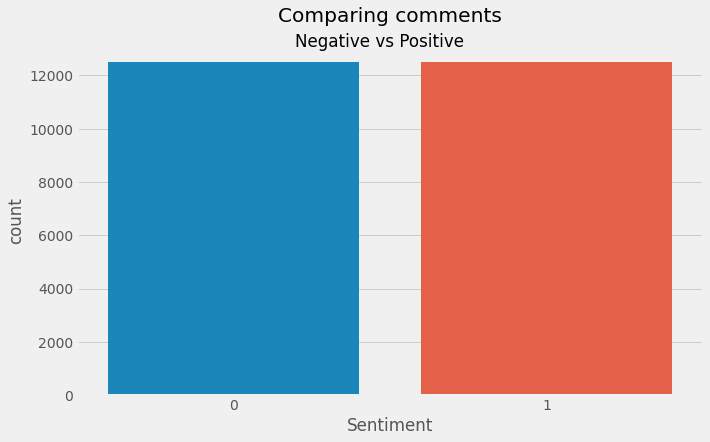

In [54]:
train_target_df = pd.DataFrame({'Sentiment': train_target}, index=range(len(train_target)))

plt.figure(figsize=(10,6))

sns.countplot(x='Sentiment', data=train_target_df)
plt.title('Comparing comments', y=1.05)
plt.suptitle('Negative vs Positive', y=0.91);

TRAIN TEST SPLIT

In [55]:
X_train = stw_train.copy()
y_train = train_target.copy()

X_test = stw_test.copy()
y_test = test_target.copy()

# Model (Random search)

In [67]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [60]:
logreg = Pipeline(steps=[
    ('vectorizer', CountVectorizer()),
    ('logreg', LogisticRegression())
])

svm = Pipeline(steps=[
    ('vectorizer', CountVectorizer()),
    ('svm', LinearSVC())
])

logreg_param = {
    'vectorizer__binary': [True],
    'vectorizer__ngram_range': [(1, 3)],
    'vectorizer__stop_words': [stop_words],
    'logreg__C': [0.01, 0.25, 0.5, 1],
    'logreg__penalty': ['l1', 'l2']
}

svm_param = {
    'vectorizer__binary': [True],
    'vectorizer__ngram_range': [(1, 3)],
    'vectorizer__stop_words': [stop_words],
    'svm__C': [0.01, 0.25, 0.5, 1],
    'svm__penalty': ['l1', 'l2']
}

logreg_search = RandomizedSearchCV(
    logreg,
    logreg_param,
    scoring = 'accuracy',
    n_jobs = -3,
    cv = 5
)

svm_search = RandomizedSearchCV(
    svm,
    svm_param,
    scoring = 'accuracy',
    n_jobs = -3,
    cv = 5
)

grids = {
    'rs_log_reg': logreg_search,
    'rs_svm': svm_search
}

In [61]:
for name, grid in grids.items():
    grid.fit(X_train, y_train)

/home/n0t10n/Documents/Projects/Sentiment_Analysis_IMB/venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/n0t10n/Documents/Projects/Sentiment_Analysis_IMB/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/n0t10n/Documents/Projects/Sentiment_Analysis_IMB/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
-----------

In [63]:
best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Score"]).sort_values(by="Score", ascending=False)
best_grids

,Grid,Score
1,rs_svm,0.87176
0,rs_log_reg,0.87168


In [74]:
best_model = svm_search.best_estimator_

print('Accuracy score:', best_model.score(X_test, y_test))

Accuracy score: 0.88756


# Export model

In [76]:
with open('data/model.pkl', 'wb') as out:
    pickle.dump(best_model, out)